In [ ]:
import pandas as pd

In [ ]:
train=pd.read_csv("/content/drive/MyDrive/train_test_split/train.csv")
test=pd.read_csv("/content/drive/MyDrive/train_test_split/test.csv")
X=train.drop(columns=['lb__Sentiment'])
y=train['lb__Sentiment']
test_X=test.drop(columns=['lb__Sentiment'])
test_y=test['lb__Sentiment']

In [ ]:
from tensorflow import keras
from keras import Sequential,regularizers
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras.layers import Dense,BatchNormalization,Dropout

In [ ]:
callback=EarlyStopping(
    monitor='loss',
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
!pip install optuna mlflow plotly==6.1.1

In [ ]:
!pip install boto3
!pip install awscli
!pip install -U kaleido
!aws configure

AWS Access Key ID [****************KTGA]: 
AWS Secret Access Key [****************J6/Z]: 
Default region name [eu-north-1]: 
Default output format [None]: 


In [ ]:
!plotly_get_chrome


Plotly will install a copy of Google Chrome to be used for generating static images of plots.
Chrome will be installed at: /usr/local/lib/python3.12/dist-packages/choreographer/cli/browser_exe
Do you want to proceed? [y/n] y
Installing Chrome for Plotly...
Chrome installed successfully.
The Chrome executable is now located at: /usr/local/lib/python3.12/dist-packages/choreographer/cli/browser_exe/chrome-linux64/chrome


In [ ]:
import mlflow
mlflow.set_tracking_uri("http://ec2-13-53-126-63.eu-north-1.compute.amazonaws.com:5000")
mlflow.set_experiment("HYP tunning")

<Experiment: artifact_location='s3://pankaj-maulekhi-mlflow/593622924682077431', creation_time=1759482905260, experiment_id='593622924682077431', last_update_time=1759482905260, lifecycle_stage='active', name='HYP tunning', tags={}>

In [ ]:
def obective(trial):
  global X,y,test_X,test_y
  layer1=trial.suggest_int('layer1',256,512)
  layer2=trial.suggest_int('layer2',128,256)
  layer3=trial.suggest_int('layer3',128,256)
  layer4=trial.suggest_int('layer4',64,128)
  layer5=trial.suggest_int('layer5',32,64)
  layer6=trial.suggest_int('layer6',32,64)
  l2=trial.suggest_float('l2',0.0001,0.01)
  activation=trial.suggest_categorical('activation',['relu','celu'])
  batch_size=trial.suggest_int('batch_size',32,256)
  dropout=trial.suggest_float('dropout',0.1,0.5)


  model=Sequential()
  model.add(Dense(layer1,activation=activation,kernel_regularizer=regularizers.L2(l2),kernel_initializer='he_normal',input_shape=(2008,)))
  model.add(BatchNormalization())
  model.add(Dense(layer2,kernel_regularizer=regularizers.L2(l2),kernel_initializer='he_normal',activation=activation))
  model.add(Dropout(dropout))
  model.add(Dense(layer3,kernel_regularizer=regularizers.L2(l2),kernel_initializer='he_normal',activation=activation))
  model.add(Dropout(dropout))
  model.add(Dense(layer4,kernel_regularizer=regularizers.L2(l2),kernel_initializer='he_normal',activation=activation))
  model.add(Dropout(dropout))
  model.add(Dense(layer5,kernel_regularizer=regularizers.L2(l2),kernel_initializer='he_normal',activation=activation))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))
  model.add(Dense(layer6,kernel_regularizer=regularizers.L2(l2),kernel_initializer='he_normal',activation=activation))
  model.add(Dense(3,activation='softmax'))
  model.compile(optimizer='Adam',metrics=["accuracy"],loss="sparse_categorical_crossentropy")
  model.fit(X,y,epochs=10,batch_size=batch_size,callbacks=callback)
  y_pred=model.predict(test_X).argmax(axis=1)
  return accuracy_score(test_y,y_pred)


In [ ]:
import optuna
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,f1_score
import plotly.express as px
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_slice, plot_contour, plot_param_importances
def tuner():
  study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
  study.optimize(obective, n_trials=30)
  best_params=study.best_params
  model=Sequential()
  model.add(Dense(best_params['layer1'],activation=best_params['activation'],kernel_regularizer=regularizers.L2(best_params['l2']),kernel_initializer='he_normal',input_shape=(2008,)))
  model.add(BatchNormalization())
  model.add(Dense(best_params['layer2'],kernel_regularizer=regularizers.L2(best_params['l2']),kernel_initializer='he_normal',activation=best_params['activation']))
  model.add(Dropout(best_params['dropout']))
  model.add(Dense(best_params['layer3'],kernel_regularizer=regularizers.L2(best_params['l2']),kernel_initializer='he_normal',activation=best_params['activation']))
  model.add(Dropout(best_params['dropout']))
  model.add(Dense(best_params['layer4'],kernel_regularizer=regularizers.L2(best_params['l2']),kernel_initializer='he_normal',activation=best_params['activation']))
  model.add(Dropout(best_params['dropout']))
  model.add(Dense(best_params['layer5'],kernel_regularizer=regularizers.L2(best_params['l2']),kernel_initializer='he_normal',activation=best_params['activation']))
  model.add(BatchNormalization())
  model.add(Dropout(best_params['dropout']))
  model.add(Dense(best_params['layer6'],kernel_regularizer=regularizers.L2(best_params['l2']),kernel_initializer='he_normal',activation=best_params['activation']))
  model.add(Dense(3,activation='softmax'))
  model.compile(optimizer='Adam',metrics=["accuracy"],loss="sparse_categorical_crossentropy")
  with mlflow.start_run():
        for trial in study.get_trials():
            with mlflow.start_run(nested=True):
                j={k:str(v) for k,v in trial.params.items()}
                mlflow.log_params(j)
                mlflow.log_metric(key='accuracy',value=float(trial.value))
        history=model.fit(X,y,epochs=10,batch_size=best_params["batch_size"],callbacks=callback)
        y_pred=model.predict(test_X).argmax(axis=1)
        pred_y_train=model.predict(X).argmax(axis=1)
        mlflow.log_params(best_params)
        mlflow.log_param("model","ann")

        mlflow.log_artifact('/content/drive/MyDrive/train_test_split/vectoriser.pkl')
        mlflow.log_artifact('/content/drive/MyDrive/train_test_split/clm_trans.pkl')

        mlflow.log_metric("accuracy",accuracy_score(test_y,y_pred))
        mlflow.log_metric("train_accuracy",accuracy_score(pred_y_train,y))

        mlflow.keras.log_model(model,artifact_path="model")
        fig=plot_optimization_history(study)
        mlflow.log_figure(fig,'optuna_optimization_history.png')
        fig=plot_param_importances(study)
        mlflow.log_figure(fig,'optuna_param_importance.png')
        fig=plot_slice(study)
        mlflow.log_figure(fig,'optuna_plot_slice.png')
        # mlflow.log_figure(px.imshow(confusion_matrix(test_y,y_pred),text_auto=True),'confusion_mat.png')

  print(study.best_trial)

In [ ]:
tuner()

[I 2025-10-03 16:48:45,306] A new study created in memory with name: no-name-356284e2-7295-40e3-b36d-17678aee2808
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.4705 - loss: 12.7827
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7205 - loss: 4.3555
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7320 - loss: 1.8648
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7366 - loss: 1.1499
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7365 - loss: 0.9375
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7432 - loss: 0.8617
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7449 - loss: 0.8364
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7495 - loss: 0.8173
Epoch 9/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7663 - loss: 0.7871
Epoch 10/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7642 - loss: 0.7817
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-10-03 16:49:52,707] Trial 0 finished with value: 0.7754825090470446 and parameters: {'layer1': 351, 'layer2': 131, 'layer3': 202, 'layer4': 94, 'layer5': 35, 'layer6': 57, 'l2': 0.008674038886974426, 'activation': 'celu', 'batch_size': 158, 'dropout': 0.4252017595381443}. Best is trial 0 with value: 0.7754825090470446.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.5956 - loss: 10.1645
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7349 - loss: 2.5878
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.7319 - loss: 1.1880
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7336 - loss: 0.9299
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7416 - loss: 0.8593
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7444 - loss: 0.8312
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7556 - loss: 0.8151
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.7695 - loss: 0.7879
Epoch 9/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7741 - loss: 0.7653
Epoch 10/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.7860 - loss: 0.7430
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-10-03 16:51:28,497] Trial 1 finished with value: 0.7864897466827503 and parameters: {'layer1': 395, 'layer2': 151, 'layer3': 233, 'layer4': 112, 'layer5': 60, 'layer6': 40, 'l2': 0.006599425058156366, 'activation': 'celu', 'batch_size': 101, 'dropout': 0.20050174977737717}. Best is trial 1 with value: 0.7864897466827503.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4292 - loss: 11.7726
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7327 - loss: 4.9073
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8365 - loss: 2.2499
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.8749 - loss: 1.3087
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8920 - loss: 0.9699
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9195 - loss: 0.7711
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9212 - loss: 0.7300
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9314 - loss: 0.6753
Epoch 9/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9373 - loss: 0.6280
Epoch 10/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9359 - loss: 0.6226
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-10-03 16:52:37,764] Trial 2 finished with value: 0.872285886610374 and parameters: {'layer1': 357, 'layer2': 217, 'layer3': 197, 'layer4': 112, 'layer5': 58, 'layer6': 34, 'l2': 0.006871823192478455, 'activation': 'relu', 'batch_size': 188, 'dropout': 0.28232906938037955}. Best is trial 2 with value: 0.872285886610374.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.5196 - loss: 15.2562
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7280 - loss: 4.6560
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.7299 - loss: 1.8986
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7275 - loss: 1.1649
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.7382 - loss: 0.9484
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7411 - loss: 0.8711
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7533 - loss: 0.8292
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7543 - loss: 0.8119
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.7633 - loss: 0.7912
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7758 - loss: 0.7731
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-10-03 16:53:51,054] Trial 3 finished with value: 0.7754825090470446 and parameters: {'layer1': 412, 'layer2': 172, 'layer3': 219, 'layer4': 66, 'layer5': 39, 'layer6': 39, 'l2': 0.009955756842564412, 'activation': 'celu', 'batch_size': 191, 'dropout': 0.3392661902128492}. Best is trial 2 with value: 0.872285886610374.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4841 - loss: 15.4845
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7114 - loss: 5.2906
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.7373 - loss: 2.2030
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7326 - loss: 1.2844
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.7426 - loss: 1.0056
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7405 - loss: 0.9078
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.7522 - loss: 0.8469
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7536 - loss: 0.8258
Epoch 9/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.7623 - loss: 0.8114
Epoch 10/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7839 - loss: 0.7693
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-10-03 16:55:04,517] Trial 4 finished with value: 0.7276839565741857 and parameters: {'layer1': 452, 'layer2': 175, 'layer3': 238, 'layer4': 99, 'layer5': 34, 'layer6': 36, 'l2': 0.00887543469920583, 'activation': 'celu', 'batch_size': 210, 'dropout': 0.4320071195415267}. Best is trial 2 with value: 0.872285886610374.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5967 - loss: 1.3497
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8006 - loss: 0.9119
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8458 - loss: 0.7864
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8683 - loss: 0.7117
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8884 - loss: 0.6515
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9016 - loss: 0.6099
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9106 - loss: 0.5759
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9246 - loss: 0.5371
Epoch 9/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9254 - loss: 0.5227
Epoch 10/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9322 - loss: 0.4978
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-10-03 16:56:10,028] Trial 5 finished with value: 0.8704764776839565 and parameters: {'layer1': 362, 'layer2': 230, 'layer3': 143, 'layer4': 99, 'layer5': 35, 'layer6': 45, 'l2': 0.0002388058747637531, 'activation': 'celu', 'batch_size': 168, 'dropout': 0.13312664373835223}. Best is trial 2 with value: 0.872285886610374.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.3581 - loss: 15.0667
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5137 - loss: 6.3773
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.6262 - loss: 2.9904
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.7727 - loss: 1.7083
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8304 - loss: 1.2332
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.8584 - loss: 1.0439
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8839 - loss: 0.9302
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8940 - loss: 0.8692
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9102 - loss: 0.7880
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9129 - loss: 0.7717
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-10-03 16:57:36,929] Trial 6 finished with value: 0.853437876960193 and parameters: {'layer1': 476, 'layer2': 208, 'layer3': 149, 'layer4': 100, 'layer5': 59, 'layer6': 48, 'l2': 0.008587152909137908, 'activation': 'relu', 'batch_size': 174, 'dropout': 0.47017917058314795}. Best is trial 2 with value: 0.872285886610374.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.5885 - loss: 12.4605
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7089 - loss: 1.9571
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7068 - loss: 1.0361
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7091 - loss: 0.9442
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7213 - loss: 0.8964
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.7382 - loss: 0.8757
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7492 - loss: 0.8389
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7515 - loss: 0.8335
Epoch 9/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7625 - loss: 0.7962
Epoch 10/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.7658 - loss: 0.7762
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-10-03 16:59:25,018] Trial 7 finished with value: 0.757086851628468 and parameters: {'layer1': 401, 'layer2': 235, 'layer3': 179, 'layer4': 87, 'layer5': 38, 'layer6': 58, 'l2': 0.009159619460302922, 'activation': 'celu', 'batch_size': 77, 'dropout': 0.24665526824981457}. Best is trial 2 with value: 0.872285886610374.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.5794 - loss: 7.3048
Epoch 2/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.7238 - loss: 2.0533
Epoch 3/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.7170 - loss: 1.0515
Epoch 4/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.7206 - loss: 0.9130
Epoch 5/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7316 - loss: 0.8540
Epoch 6/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.7418 - loss: 0.8284
Epoch 7/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.7604 - loss: 0.7973
Epoch 8/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.7614 - loss: 0.7850
Epoch 9/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7618 - loss: 0.7629
Epoch 10/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7779 - loss: 0.7308
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


[I 2025-10-03 17:01:50,904] Trial 8 finished with value: 0.7892038600723763 and parameters: {'layer1': 277, 'layer2': 233, 'layer3': 190, 'layer4': 119, 'layer5': 51, 'layer6': 32, 'l2': 0.004803557975074114, 'activation': 'celu', 'batch_size': 53, 'dropout': 0.27026379813393286}. Best is trial 2 with value: 0.872285886610374.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5733 - loss: 14.2383
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.7339 - loss: 3.7189
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7325 - loss: 1.4549
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7349 - loss: 1.0083
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7387 - loss: 0.8769
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7504 - loss: 0.8212
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7576 - loss: 0.8123
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7597 - loss: 0.8006
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7681 - loss: 0.7697
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.7656 - loss: 0.7802
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-10-03 17:03:03,652] Trial 9 finished with value: 0.7439686369119421 and parameters: {'layer1': 307, 'layer2': 236, 'layer3': 197, 'layer4': 87, 'layer5': 53, 'layer6': 36, 'l2': 0.009672574505369328, 'activation': 'celu', 'batch_size': 149, 'dropout': 0.2010728101747018}. Best is trial 2 with value: 0.872285886610374.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.3830 - loss: 8.2652
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5505 - loss: 5.5618
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7396 - loss: 3.6854
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8481 - loss: 2.4141
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8939 - loss: 1.6545
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9140 - loss: 1.2215
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9351 - loss: 0.9412
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9395 - loss: 0.7800
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9483 - loss: 0.6896
Epoch 10/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9570 - loss: 0.6063
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


[I 2025-10-03 17:03:55,028] Trial 10 finished with value: 0.8772617611580217 and parameters: {'layer1': 323, 'layer2': 256, 'layer3': 165, 'layer4': 124, 'layer5': 64, 'layer6': 50, 'l2': 0.0037913557622879517, 'activation': 'relu', 'batch_size': 251, 'dropout': 0.3305158108955757}. Best is trial 10 with value: 0.8772617611580217.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.4143 - loss: 8.0002
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6198 - loss: 5.3086
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7715 - loss: 3.4242
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8604 - loss: 2.2157
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8971 - loss: 1.5226
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9211 - loss: 1.1226
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9315 - loss: 0.8841
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9454 - loss: 0.7211
Epoch 9/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9454 - loss: 0.6492
Epoch 10/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9496 - loss: 0.5905
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-10-03 17:04:47,918] Trial 11 finished with value: 0.8754523522316043 and parameters: {'layer1': 321, 'layer2': 255, 'layer3': 163, 'layer4': 128, 'layer5': 64, 'layer6': 51, 'l2': 0.003826863510165235, 'activation': 'relu', 'batch_size': 256, 'dropout': 0.3457754442183201}. Best is trial 10 with value: 0.8772617611580217.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.3859 - loss: 6.8122
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.5728 - loss: 4.9343
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7469 - loss: 3.5194
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8413 - loss: 2.4604
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8908 - loss: 1.7672
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9143 - loss: 1.3177
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9326 - loss: 1.0265
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9395 - loss: 0.8460
Epoch 9/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9466 - loss: 0.7136
Epoch 10/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9488 - loss: 0.6414
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-10-03 17:05:39,104] Trial 12 finished with value: 0.870627261761158 and parameters: {'layer1': 308, 'layer2': 256, 'layer3': 164, 'layer4': 123, 'layer5': 63, 'layer6': 53, 'l2': 0.003036687913439363, 'activation': 'relu', 'batch_size': 256, 'dropout': 0.35193546905766837}. Best is trial 10 with value: 0.8772617611580217.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.3808 - loss: 5.6063
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5257 - loss: 4.3373
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6999 - loss: 3.2561
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8148 - loss: 2.3973
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8742 - loss: 1.7794
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9147 - loss: 1.3454
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9253 - loss: 1.0768
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9393 - loss: 0.8737
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9481 - loss: 0.7359
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9537 - loss: 0.6465
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-10-03 17:06:24,600] Trial 13 finished with value: 0.8772617611580217 and parameters: {'layer1': 261, 'layer2': 256, 'layer3': 128, 'layer4': 128, 'layer5': 64, 'layer6': 63, 'l2': 0.0025657293328182882, 'activation': 'relu', 'batch_size': 248, 'dropout': 0.3581056798572469}. Best is trial 10 with value: 0.8772617611580217.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.3866 - loss: 3.8826
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5400 - loss: 3.0514
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6706 - loss: 2.4232
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7889 - loss: 1.8871
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8670 - loss: 1.4556
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9101 - loss: 1.1482
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9325 - loss: 0.9453
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9377 - loss: 0.8127
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9488 - loss: 0.6968
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9541 - loss: 0.6147
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-10-03 17:07:11,974] Trial 14 finished with value: 0.8712303980699638 and parameters: {'layer1': 257, 'layer2': 199, 'layer3': 129, 'layer4': 114, 'layer5': 44, 'layer6': 64, 'l2': 0.0017031728896939034, 'activation': 'relu', 'batch_size': 225, 'dropout': 0.39220451456315486}. Best is trial 10 with value: 0.8772617611580217.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3685 - loss: 5.6728
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.4863 - loss: 3.9725
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6355 - loss: 2.7050
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7729 - loss: 1.8405
Epoch 5/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8527 - loss: 1.3073
Epoch 6/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8911 - loss: 1.0192
Epoch 7/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9136 - loss: 0.8464
Epoch 8/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9253 - loss: 0.7509
Epoch 9/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9315 - loss: 0.6863
Epoch 10/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9374 - loss: 0.6471
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-10-03 17:08:22,428] Trial 15 finished with value: 0.8718335343787696 and parameters: {'layer1': 277, 'layer2': 256, 'layer3': 128, 'layer4': 127, 'layer5': 55, 'layer6': 63, 'l2': 0.0026508330891834115, 'activation': 'relu', 'batch_size': 119, 'dropout': 0.4843783832201538}. Best is trial 10 with value: 0.8772617611580217.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.3862 - loss: 3.2715
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6031 - loss: 2.5586
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7743 - loss: 2.0037
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8677 - loss: 1.5762
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9066 - loss: 1.2799
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9321 - loss: 1.0554
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9389 - loss: 0.9132
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9503 - loss: 0.7758
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9543 - loss: 0.6965
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9623 - loss: 0.6196
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-10-03 17:09:19,878] Trial 16 finished with value: 0.876357056694813 and parameters: {'layer1': 319, 'layer2': 183, 'layer3': 164, 'layer4': 68, 'layer5': 48, 'layer6': 59, 'l2': 0.001295669109887323, 'activation': 'relu', 'batch_size': 226, 'dropout': 0.3164704532965724}. Best is trial 10 with value: 0.8772617611580217.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.3820 - loss: 8.4758
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5465 - loss: 5.4825
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7168 - loss: 3.3638
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8333 - loss: 2.0848
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8767 - loss: 1.4175
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9095 - loss: 1.0393
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9315 - loss: 0.8177
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9376 - loss: 0.7083
Epoch 9/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9391 - loss: 0.6563
Epoch 10/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9444 - loss: 0.6057
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-10-03 17:10:06,897] Trial 17 finished with value: 0.8725874547647768 and parameters: {'layer1': 259, 'layer2': 213, 'layer3': 147, 'layer4': 106, 'layer5': 64, 'layer6': 45, 'l2': 0.004866277835118522, 'activation': 'relu', 'batch_size': 237, 'dropout': 0.3856650696477052}. Best is trial 10 with value: 0.8772617611580217.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.4612 - loss: 10.7426
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7483 - loss: 5.2605
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8514 - loss: 2.6425
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8849 - loss: 1.5341
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9079 - loss: 1.0636
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9218 - loss: 0.8398
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9288 - loss: 0.7363
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9394 - loss: 0.6604
Epoch 9/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9442 - loss: 0.6214
Epoch 10/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9457 - loss: 0.5922
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-10-03 17:11:12,818] Trial 18 finished with value: 0.8629372738238842 and parameters: {'layer1': 336, 'layer2': 243, 'layer3': 172, 'layer4': 121, 'layer5': 56, 'layer6': 53, 'l2': 0.005879052899113783, 'activation': 'relu', 'batch_size': 202, 'dropout': 0.21102280484118618}. Best is trial 10 with value: 0.8772617611580217.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.4472 - loss: 7.7203
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7527 - loss: 4.7392
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8650 - loss: 2.8446
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9027 - loss: 1.8187
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9253 - loss: 1.2516
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9355 - loss: 0.9379
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9401 - loss: 0.7645
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9419 - loss: 0.6706
Epoch 9/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9493 - loss: 0.6029
Epoch 10/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9526 - loss: 0.5562
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-10-03 17:12:11,019] Trial 19 finished with value: 0.8742460796139928 and parameters: {'layer1': 295, 'layer2': 221, 'layer3': 253, 'layer4': 79, 'layer5': 46, 'layer6': 61, 'l2': 0.0038736283684722714, 'activation': 'relu', 'batch_size': 238, 'dropout': 0.14109142786440307}. Best is trial 10 with value: 0.8772617611580217.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.4132 - loss: 5.2420
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6020 - loss: 3.6460
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.7808 - loss: 2.4983
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8502 - loss: 1.7424
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8916 - loss: 1.2845
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9165 - loss: 1.0101
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9266 - loss: 0.8513
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9359 - loss: 0.7467
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9426 - loss: 0.6709
Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9453 - loss: 0.6240
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-10-03 17:13:35,883] Trial 20 finished with value: 0.8801266586248492 and parameters: {'layer1': 434, 'layer2': 247, 'layer3': 142, 'layer4': 118, 'layer5': 61, 'layer6': 55, 'l2': 0.0021240383016763783, 'activation': 'relu', 'batch_size': 129, 'dropout': 0.3927200956196992}. Best is trial 20 with value: 0.8801266586248492.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4029 - loss: 5.1111
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6304 - loss: 3.3426
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8059 - loss: 2.1590
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8686 - loss: 1.4778
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9001 - loss: 1.1033
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9216 - loss: 0.8907
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9287 - loss: 0.7738
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9351 - loss: 0.6937
Epoch 9/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9453 - loss: 0.6277
Epoch 10/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9452 - loss: 0.5934
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-10-03 17:15:03,090] Trial 21 finished with value: 0.8798250904704463 and parameters: {'layer1': 432, 'layer2': 243, 'layer3': 141, 'layer4': 118, 'layer5': 61, 'layer6': 55, 'l2': 0.00217166402283992, 'activation': 'relu', 'batch_size': 118, 'dropout': 0.38179162441038994}. Best is trial 20 with value: 0.8801266586248492.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.3999 - loss: 3.8694
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.6026 - loss: 2.9053
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.7749 - loss: 2.1735
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8468 - loss: 1.6441
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8885 - loss: 1.2860
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9127 - loss: 1.0416
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9279 - loss: 0.8755
Epoch 8/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9351 - loss: 0.7806
Epoch 9/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9482 - loss: 0.6603
Epoch 10/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9464 - loss: 0.6178
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-10-03 17:16:37,934] Trial 22 finished with value: 0.8855548854041013 and parameters: {'layer1': 440, 'layer2': 244, 'layer3': 152, 'layer4': 117, 'layer5': 61, 'layer6': 55, 'l2': 0.0013450318715991386, 'activation': 'relu', 'batch_size': 125, 'dropout': 0.40659342947433236}. Best is trial 22 with value: 0.8855548854041013.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.3903 - loss: 2.4372
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.5653 - loss: 1.8764
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.6982 - loss: 1.5885
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8006 - loss: 1.3363
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8769 - loss: 1.0861
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9079 - loss: 0.9423
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9235 - loss: 0.8507
Epoch 8/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9431 - loss: 0.7478
Epoch 9/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9438 - loss: 0.7019
Epoch 10/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9596 - loss: 0.6178
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


[I 2025-10-03 17:18:05,036] Trial 23 finished with value: 0.8846501809408926 and parameters: {'layer1': 426, 'layer2': 244, 'layer3': 142, 'layer4': 116, 'layer5': 60, 'layer6': 55, 'l2': 0.0005570068523030012, 'activation': 'relu', 'batch_size': 130, 'dropout': 0.42977396675192536}. Best is trial 22 with value: 0.8855548854041013.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.3746 - loss: 2.0670
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.5011 - loss: 1.5544
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6138 - loss: 1.3236
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.7270 - loss: 1.1463
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8252 - loss: 0.9633
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8842 - loss: 0.8049
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9175 - loss: 0.7068
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9394 - loss: 0.6371
Epoch 9/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9517 - loss: 0.5732
Epoch 10/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9499 - loss: 0.5519
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-10-03 17:19:52,732] Trial 24 finished with value: 0.8873642943305187 and parameters: {'layer1': 504, 'layer2': 198, 'layer3': 155, 'layer4': 106, 'layer5': 57, 'layer6': 56, 'l2': 0.00030010966610110484, 'activation': 'relu', 'batch_size': 126, 'dropout': 0.45016460665006025}. Best is trial 24 with value: 0.8873642943305187.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.3949 - loss: 1.7079
Epoch 2/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.5658 - loss: 1.2603
Epoch 3/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7266 - loss: 1.0416
Epoch 4/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8351 - loss: 0.8346
Epoch 5/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8949 - loss: 0.6918
Epoch 6/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.9158 - loss: 0.6178
Epoch 7/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9340 - loss: 0.5632
Epoch 8/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9495 - loss: 0.5109
Epoch 9/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9543 - loss: 0.4845
Epoch 10/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9591 - loss: 0.4494
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-10-03 17:22:15,528] Trial 25 finished with value: 0.882086851628468 and parameters: {'layer1': 508, 'layer2': 197, 'layer3': 155, 'layer4': 106, 'layer5': 56, 'layer6': 60, 'l2': 0.00020815055895205656, 'activation': 'relu', 'batch_size': 91, 'dropout': 0.4407716075049464}. Best is trial 24 with value: 0.8873642943305187.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.3824 - loss: 3.2235
Epoch 2/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.5888 - loss: 2.3317
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.7210 - loss: 1.7203
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8245 - loss: 1.2960
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.8680 - loss: 1.0519
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.8900 - loss: 0.9074
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.9102 - loss: 0.7999
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9258 - loss: 0.7262
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9283 - loss: 0.6932
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9352 - loss: 0.6494
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-10-03 17:24:48,908] Trial 26 finished with value: 0.8716827503015682 and parameters: {'layer1': 506, 'layer2': 159, 'layer3': 182, 'layer4': 107, 'layer5': 51, 'layer6': 56, 'l2': 0.001109194213153704, 'activation': 'relu', 'batch_size': 61, 'dropout': 0.4951845333983862}. Best is trial 24 with value: 0.8873642943305187.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
829/829 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.4168 - loss: 2.4188
Epoch 2/10
829/829 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.6888 - loss: 1.7050
Epoch 3/10
829/829 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.8100 - loss: 1.2708
Epoch 4/10
829/829 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.8598 - loss: 1.0085
Epoch 5/10
829/829 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.8847 - loss: 0.8587
Epoch 6/10
829/829 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.9033 - loss: 0.7595
Epoch 7/10
829/829 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - accuracy: 0.9096 - loss: 0.7284
Epoch 8/10
829/829 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - accuracy: 0.9181 - loss: 0.6769
Epoch 9/10
829/829 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.9229 - loss: 0.6627
Epoch 10/10
829/829 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.9308 - loss: 0.6192
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


[I 2025-10-03 17:29:57,433] Trial 27 finished with value: 0.8769601930036188 and parameters: {'layer1': 481, 'layer2': 225, 'layer3': 156, 'layer4': 113, 'layer5': 58, 'layer6': 52, 'l2': 0.0006659942392712231, 'activation': 'relu', 'batch_size': 32, 'dropout': 0.4201039280640213}. Best is trial 24 with value: 0.8873642943305187.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.3753 - loss: 3.1111
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.5127 - loss: 2.4778
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.6309 - loss: 2.0548
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7423 - loss: 1.7012
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8410 - loss: 1.3599
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8841 - loss: 1.1360
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9126 - loss: 0.9687
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9331 - loss: 0.8353
Epoch 9/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9432 - loss: 0.7476
Epoch 10/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9425 - loss: 0.6955
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


[I 2025-10-03 17:31:35,179] Trial 28 finished with value: 0.8757539203860072 and parameters: {'layer1': 473, 'layer2': 205, 'layer3': 137, 'layer4': 108, 'layer5': 53, 'layer6': 48, 'l2': 0.0009157655885388605, 'activation': 'relu', 'batch_size': 137, 'dropout': 0.4681401635734001}. Best is trial 24 with value: 0.8873642943305187.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.3690 - loss: 4.0565
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5111 - loss: 3.0855
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6554 - loss: 2.3555
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.7873 - loss: 1.7788
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8508 - loss: 1.3933
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8906 - loss: 1.1393
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9140 - loss: 0.9541
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9250 - loss: 0.8428
Epoch 9/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9346 - loss: 0.7536
Epoch 10/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9411 - loss: 0.6912
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


[I 2025-10-03 17:32:58,410] Trial 29 finished with value: 0.8772617611580217 and parameters: {'layer1': 450, 'layer2': 139, 'layer3': 155, 'layer4': 93, 'layer5': 61, 'layer6': 57, 'l2': 0.0015998838308789766, 'activation': 'relu', 'batch_size': 153, 'dropout': 0.4477139884655708}. Best is trial 24 with value: 0.8873642943305187.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



🏃 View run indecisive-frog-95 at: http://ec2-13-53-126-63.eu-north-1.compute.amazonaws.com:5000/#/experiments/593622924682077431/runs/12097bd59bf8481c9bf086966fa3219e
🧪 View experiment at: http://ec2-13-53-126-63.eu-north-1.compute.amazonaws.com:5000/#/experiments/593622924682077431
🏃 View run worried-fox-324 at: http://ec2-13-53-126-63.eu-north-1.compute.amazonaws.com:5000/#/experiments/593622924682077431/runs/a781ee770feb4225b051bb057d00495e
🧪 View experiment at: http://ec2-13-53-126-63.eu-north-1.compute.amazonaws.com:5000/#/experiments/593622924682077431
🏃 View run bustling-ape-167 at: http://ec2-13-53-126-63.eu-north-1.compute.amazonaws.com:5000/#/experiments/593622924682077431/runs/b60fbfe2a5bb4945b470c384d823809d
🧪 View experiment at: http://ec2-13-53-126-63.eu-north-1.compute.amazonaws.com:5000/#/experiments/593622924682077431
🏃 View run rambunctious-cub-612 at: http://ec2-13-53-126-63.eu-north-1.compute.amazonaws.com:5000/#/experiments/593622924682077431/runs/70794a6ca513408a8

2025/10/03 17:35:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/03 17:35:44 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/03 17:35:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run fun-kite-389 at: http://ec2-13-53-126-63.eu-north-1.compute.amazonaws.com:5000/#/experiments/593622924682077431/runs/ff50171cbd6d47ffaaf9c4e8d9f41fcd
🧪 View experiment at: http://ec2-13-53-126-63.eu-north-1.compute.amazonaws.com:5000/#/experiments/593622924682077431
FrozenTrial(number=24, state=1, values=[0.8873642943305187], datetime_start=datetime.datetime(2025, 10, 3, 17, 18, 5, 37861), datetime_complete=datetime.datetime(2025, 10, 3, 17, 19, 52, 732383), params={'layer1': 504, 'layer2': 198, 'layer3': 155, 'layer4': 106, 'layer5': 57, 'layer6': 56, 'l2': 0.00030010966610110484, 'activation': 'relu', 'batch_size': 126, 'dropout': 0.45016460665006025}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'layer1': IntDistribution(high=512, log=False, low=256, step=1), 'layer2': IntDistribution(high=256, log=False, low=128, step=1), 'layer3': IntDistribution(high=256, log=False, low=128, step=1), 'layer4': IntDistribution(high=128, log=False, low=64, step=

In [ ]:
history=model.fit(X,y,epochs=20,validation_split=0.1,batch_size=64,callbacks=callback)

Epoch 1/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.4226 - loss: 1.4211 - val_accuracy: 0.5760 - val_loss: 1.0435
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6265 - loss: 0.9909 - val_accuracy: 0.7441 - val_loss: 0.8365
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7725 - loss: 0.7892 - val_accuracy: 0.7927 - val_loss: 0.7399
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8558 - loss: 0.6110 - val_accuracy: 0.8349 - val_loss: 0.6920
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9078 - loss: 0.5007 - val_accuracy: 0.8428 - val_loss: 0.6834
Epoch 6/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9287 - loss: 0.4456 - val_accuracy: 0.8669 - val_loss: 0.6579
Epoch 7/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9472 - loss: 0.3977 - val_accuracy: 0.8628 - val_loss: 0.6947
Epoch 8/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9561 - loss: 0.3659 - val_accuracy:

In [ ]:
history=pd.DataFrame(history.history)

<Axes: >

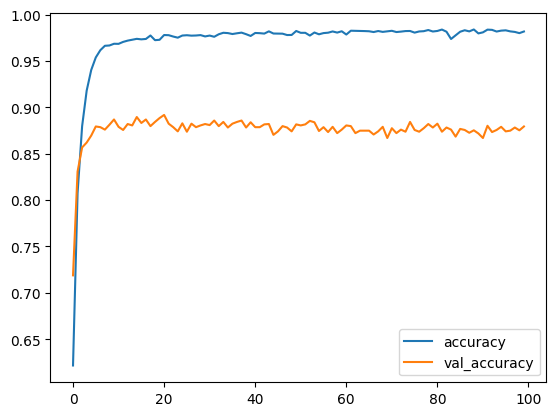

In [ ]:
history[['accuracy','val_accuracy']].plot(kind='line')

In [ ]:
y_pred=model.predict(test_X).argmax(axis=1)
accuracy_score(test_y,y_pred)

208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


0.8911338962605548

In [ ]:
confusion_matrix(test_y,y_pred)

array([[2081,   74,   32],
       [  73, 1986,  143],
       [  76,  324, 1843]])

In [ ]:
precision_score(test_y,y_pred,average=None),recall_score(test_y,y_pred,average=None),f1_score(test_y,y_pred,average=None)

(array([0.90449679, 0.87799043, 0.87720888]),
 array([0.96570645, 0.83333333, 0.86312974]),
 array([0.93409996, 0.85507922, 0.87011236]))